In [1]:
import alborexdata
import netCDF4
import glob
import os
import json
import scipy.io as sio
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import datetime
import cmocean
from importlib import reload

In [2]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [3]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

In [4]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

In [5]:
logger = alborexdata.configure_logging("./logs/alborexFigure7.log")

### Domain

In [6]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

In [14]:
figdir = config["figdir"]
datadir = config["datadirs"]["profilers"]
datafilelist = sorted(glob.glob(os.path.join(datadir, "*.nc")))
coastfile = config["datafiles"]["coast"]
datafilelist

['/home/ctroupin/Data/Alborex/Profilers/dep0001_profiler-drifter-arvora3001_ogs-arvora3001_L1_2014-05-25.nc',
 '/home/ctroupin/Data/Alborex/Profilers/dep0001_profiler-drifter-arvorc_socib_arvorc_L0_2014-05-25.nc',
 '/home/ctroupin/Data/Alborex/Profilers/dep0001_profiler-drifter-provbioll001_ogs-provbioll001_L1_2014-05-25.nc']

## Load data 
### Coastline

In [8]:
if os.path.exists(coastfile):
    logger.info("{0} exists".format(coastfile))
    loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)
else:
    logger.warning("{0} does't exist".format(coastfile))  

2018-08-23 11:47:17,707 - alborex_logger - INFO - /home/ctroupin/Data/Alborex/Coastline/coastline_f.dat exists


### Front position

In [9]:
frontcoords = "../data/front_coordinates.dat"
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

## Plot

Create the projection

In [10]:
coordinates = (-1.5, 1., 35.25, 37.25)
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            lat_ts=0.5 * (coordinates[2] + coordinates[3]), resolution='h')

## Loop on the files

In [28]:
figname = "fig08a"
figtitle = "Profiling floats trajectories"
logger.info("Making figure {0}".format(figname))
finaldate = datetime.datetime(2014, 6, 15)

tmin, tmax = 18., 20.5

fig = plt.figure(figsize=(14, 10))
# 1st subplot: trajectories

ax0 = plt.subplot(2, 2, 1)
m.ax = ax0

# Add the coastline
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True, zorder=4, ax=ax0)

alborexdata.add_map_grid(m, coordinates, dlon=.5, dlat=.5,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6", ax=ax0)

m.fillcontinents(color="w", zorder=3, ax=ax0)
# Front position
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True, zorder=5, alpha=.7)
plt.title(figtitle, fontsize=18)

colorlist = ["b", "g", "k"]
stylelist = ["-", "-.", "-"]
namelist = ["Arvor-A3", "Arvor-C", "Provor-bio"]

ii = 0
for datafiles in datafilelist:
    
    logger.debug("Working on file: {0}".format(os.path.basename(datafiles)))
    
    # Read data from file
    p = alborexdata.Profiler()
    p.get_from_netcdf(datafiles)
    # p.select_dates(finaldate=finaldate)

    # Hard-coded !!!!
    # because the 1st profiler has some issues in the first positions
    if ii == 0:
        p.lon = p.lon[3:]
        p.lat = p.lat[3:]
        p.dates = p.dates[3:]
        p.depth = p.depth[3:, :]
        p.temperature = p.temperature[3:, :]
        p.salinity = p.salinity[3:, :]
    
    
    
    m.plot(p.lon, p.lat, "o:", color=colorlist[ii], 
           linestyle=stylelist[ii], ms=4, latlon=True, label=namelist[ii])
    
    ii += 1
    
    # Select good dates
    p.select_dates(finaldate=finaldate)
    ndepth = p.depth.shape[1]
    dates = np.matlib.repmat(p.dates.T, ndepth, 1)
    dates = dates.transpose()

    ax = plt.subplot(2, 2, ii+1)
    #ax2.plot(p.salinity, p.temperature, "ko", ms=2)
    scat = ax.scatter(dates, p.depth, s=4, c=p.salinity, 
                      vmin=36.75, vmax=38.5,
                      cmap=cmocean.cm.haline)
    ax.set_title(namelist[ii-1], fontsize=18)
    plt.yticks(range(0, 500, 100))
    plt.ylim(0, 400.)
    plt.ylabel("Depth\n(m)", fontsize=14, rotation=0, ha="right")
    plt.xlim(datetime.datetime(2014, 5, 25), finaldate)
    cb = plt.colorbar(scat, extend="both")
    cb.set_label("S", rotation=0, fontsize=14)
    plt.gca().invert_yaxis()
    plt.tick_params(axis='both', which='major', labelsize=12)
    fig.autofmt_xdate()


ax.set_title(namelist[ii-1], fontsize=18)
plt.ylim(0, 400.)
plt.xlim(datetime.datetime(2014, 5, 25), finaldate)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=12)
fig.autofmt_xdate()
# ---------------------------------------------------


ax0.legend(fontsize=16, loc=4)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')

# plt.show()
plt.close()

2018-08-23 14:55:40,168 - alborex_logger - INFO - Making figure fig08a
2018-08-23 14:55:40,245 - alborex_logger - DEBUG - Working on file: dep0001_profiler-drifter-arvora3001_ogs-arvora3001_L1_2014-05-25.nc
2018-08-23 14:55:40,370 - alborex_logger - DEBUG - Working on file: dep0001_profiler-drifter-arvorc_socib_arvorc_L0_2014-05-25.nc
2018-08-23 14:55:55,896 - alborex_logger - DEBUG - Working on file: dep0001_profiler-drifter-provbioll001_ogs-provbioll001_L1_2014-05-25.nc


In [46]:
p = alborexdata.Profiler()
p.get_from_netcdf(datafilelist[1]) 
p.select_dates(finaldate=datetime.datetime(2014, 6, 14))

In [52]:
p.dates.count()

455

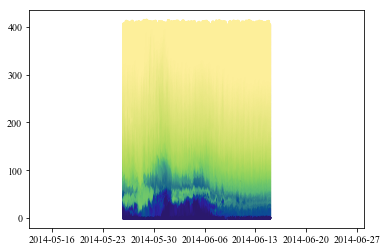

In [44]:
ndepth = p.depth.shape[1]
dates = np.matlib.repmat(p.dates.T, ndepth, 1)
dates = dates.transpose()
scat = plt.scatter(dates, p.depth, s=4, c=p.salinity, 
                   vmin=36.75, vmax=38.5,
                   cmap=cmocean.cm.haline)
plt.show()
plt.close()

## T-S diagram

2018-08-02 22:08:41,535 - alborex_logger - INFO - Making figure fig08b
2018-08-02 22:08:41,579 - alborex_logger - DEBUG - Working on file: dep0001_profiler-drifter-provbioll001_ogs-provbioll001_L1_2014-05-25.nc


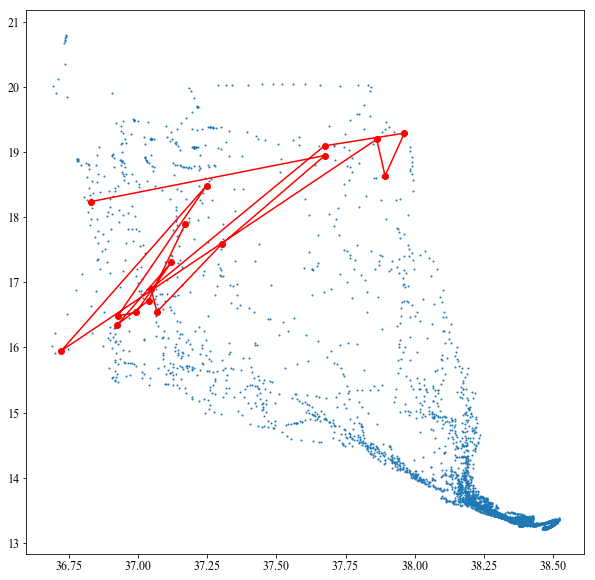

In [44]:
figname = "fig08b"
figtitle = "Profiling floats trajectories"
logger.info("Making figure {0}".format(figname))
finaldate = datetime.datetime(2014, 6, 15)

fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot(111)

ii = 0
for datafiles in datafilelist:
    
    logger.debug("Working on file: {0}".format(os.path.basename(datafiles)))
    
    # Read data from file
    p = alborexdata.Profiler()
    p.get_from_netcdf(datafiles)
    p.select_dates(finaldate=finaldate)

    # Hard-coded !!!!
    # because the 1st profiler has some issues in the first positions
    """
    if ii == -1:
        p.lon = p.lon[3:]
        p.lat = p.lat[3:]
        p.dates = p.dates[3:]
        p.depth = p.depth[3:, :]
        p.temperature = p.temperature[3:, :]
        p.salinity = p.salinity[3:, :]
    """
  
    
    plt.plot(p.salinity.compressed(), p.temperature.compressed(), "o", ms=1)

np = p.depth.shape[0]
depth4interp = 25
t, s = [], []
ii = 0
dd = p.dates[0]
while (dd <= finaldate):
    depthinterp = p.depth[ii]
    tempinterp = p.temperature[ii]
    saltinterp = p.salinity[ii]
    f1 = interpolate.interp1d(depthinterp, tempinterp)
    f2 = interpolate.interp1d(depthinterp, saltinterp)
    t.append(f1(depth4interp))
    s.append(f2(depth4interp))
    ii += 1
    dd = p.dates.data[ii]
    
plt.plot(s, t, "ro-")
plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')

plt.show()
plt.close()